Authors:
<br />
Arsh Lalani, Faculty of Engineering, Western University 
<br />
Andrew Harrop, Faculty of Engineering, Western University

External Libraries:

In [1]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import imutils

import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical




Internal Libraries:

In [2]:
# Internal libraries:
from Helpers.load_images import load_images

from Helpers.preprocessing import multiple_dataset_conversion
from Helpers.preprocessing import crop_images
from Helpers.preprocessing import preprocess_images
from Helpers.preprocessing import augment_image_set
from Helpers.preprocessing import labels_to_categorical

from Helpers.plotting import plot_image_classes
from Helpers.plotting import plot_history
from Helpers.plotting import plot_image
from Helpers.plotting import plot_augmented

from Helpers.evaluate import evalute_model


from Models.CNN import build_cnn 
from Models.CNN import train_cnn 

from Models.VGG16 import build_vgg16 
from Models.VGG16 import train_vgg16

from Models.RESNET import build_resnet
from Models.RESNET import train_resnet



Load images from the dataset

In [4]:
dataset_1_tumor_images, dataset_1_normal_images = load_images(1)
dataset_2_tumor_images, dataset_2_normal_images = load_images(2)

/Users/arshlalani/Desktop/Current Courses/AI 2/Advanced-AI-Thesis/Helpers/plotting.py:63: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("Image Labels")


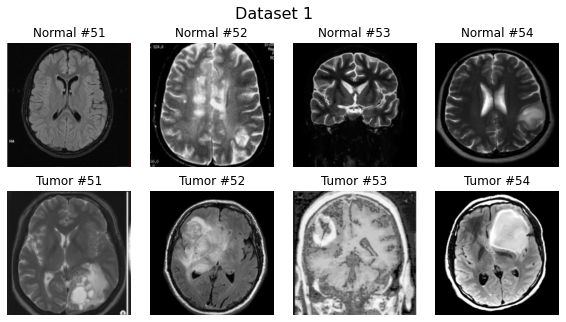

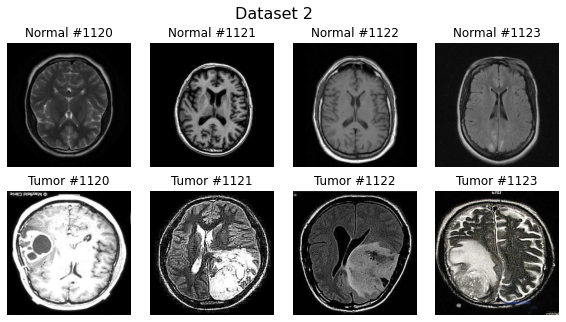

In [5]:
plot_image_classes(dataset_1_normal_images, dataset_1_tumor_images, n_images=4, title="Dataset 1")
plot_image_classes(dataset_2_normal_images, dataset_2_tumor_images, n_images=4, title="Dataset 2")

Crop the brain into the full view

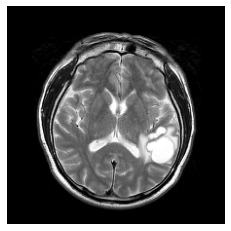

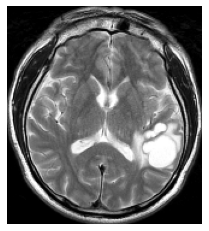

In [6]:
plot_image(dataset_1_tumor_images[4], save="uncropped_test")
dataset_1_tumor_images_proc = crop_images(dataset_1_tumor_images)
dataset_1_normal_images_proc = crop_images(dataset_1_normal_images)
dataset_2_tumor_images_proc = crop_images(dataset_2_tumor_images)
dataset_2_normal_images_proc = crop_images(dataset_2_normal_images)

test_image = dataset_1_tumor_images_proc[4]
plot_image(test_image, save="cropped_test")

In [7]:
dataset_1_normal_images_proc = preprocess_images(dataset_1_normal_images_proc, (224, 224))
dataset_1_tumor_images_proc = preprocess_images(dataset_1_tumor_images_proc, (224, 224))
dataset_2_normal_images_proc = preprocess_images(dataset_2_normal_images_proc, (224, 224))
dataset_2_tumor_images_proc = preprocess_images(dataset_2_tumor_images_proc, (224, 224))

Split the datasets. The light dataset contains many fewer images, which is convenient for testing preliminary models.

In [8]:
X, Y = multiple_dataset_conversion(yes = [dataset_1_normal_images_proc, dataset_2_normal_images_proc], no = [dataset_1_tumor_images_proc, dataset_2_tumor_images_proc])
X_light, Y_light = multiple_dataset_conversion(yes = [dataset_1_normal_images], no = [dataset_1_tumor_images])

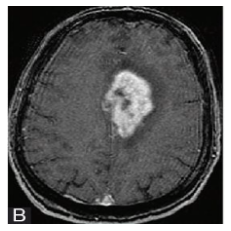

In [9]:
# Sp;it into train, test, and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42, stratify=Y_test)

X_light_train, X_light_test, Y_light_train, Y_light_test = train_test_split(X_light, Y_light, test_size=0.2, random_state=42, stratify=Y_light)
X_light_test, X_light_val, Y_light_test, Y_light_val = train_test_split(X_light_test, Y_light_test, test_size=0.5, random_state=42, stratify=Y_light_test)

plot_image(X_light_train[0], save="X_light_train")

Preform some data augmentation on the training data

In [10]:
example_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


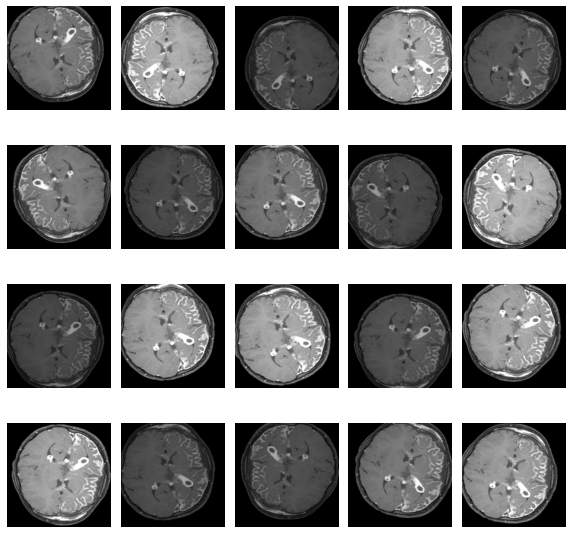

In [11]:
plot_augmented(X_light_train[5], example_datagen)

In [12]:
# Applting augmentation to the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)




        

In [13]:
X_train = np.array(X_train)
Y_train = labels_to_categorical(np.array(Y_train))

X_test = np.array(X_test)
Y_test = labels_to_categorical(np.array(Y_test))

X_val = np.array(X_val)
Y_val = labels_to_categorical(np.array(Y_val))

X_light_train = np.array(X_light_train)
Y_light_train = labels_to_categorical(np.array(Y_light_train))

X_light_test = np.array(X_light_test)
Y_light_test = labels_to_categorical(np.array(Y_light_test))

X_light_val = np.array(X_light_val)
Y_light_val = labels_to_categorical(np.array(Y_light_val))

train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=16)
validation_generator = test_datagen.flow(X_val, Y_val, batch_size=16)

train_light_generator = train_datagen.flow(X_light_train, Y_light_train, batch_size=8)
test_light_generator = test_datagen.flow(X_light_test, Y_light_test, batch_size=4)
validation_light_generator = test_datagen.flow(X_light_val, Y_light_val, batch_size=4)

Data is now ready to be used for training.

Model 1 is a simple CNN, no fancy model here.

In [14]:
model_1 = build_cnn()
model_1.summary()

2022-04-08 14:09:31.312742: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0     

In [15]:
history_1 = train_cnn(model_1, X_light_train, Y_light_train, X_light_val, Y_light_val, epochs=25, batch_size=32)

2022-04-08 14:09:43.809848: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
7/7 [==============================] - 8s 967ms/step - loss: 1.0820 - accuracy: 0.6386 - val_loss: 4.4593 - val_accuracy: 0.7308
Epoch 2/25
7/7 [==============================] - 7s 1s/step - loss: 0.6157 - accuracy: 0.7822 - val_loss: 3.0770 - val_accuracy: 0.7308
Epoch 3/25
7/7 [==============================] - 7s 979ms/step - loss: 0.5370 - accuracy: 0.7723 - val_loss: 1.8310 - val_accuracy: 0.7308
Epoch 4/25
7/7 [==============================] - 6s 883ms/step - loss: 0.4512 - accuracy: 0.8168 - val_loss: 1.0140 - val_accuracy: 0.7308
Epoch 5/25
7/7 [==============================] - 6s 875ms/step - loss: 0.4099 - accuracy: 0.8317 - val_loss: 0.8133 - val_accuracy: 0.8077
Epoch 6/25
7/7 [==============================] - 6s 896ms/step - loss: 0.3376 - accuracy: 0.8416 - val_loss: 0.7720 - val_accuracy: 0.7692
Epoch 7/25
7/7 [==============================] - 9s 1s/step - loss: 0.3069 - accuracy: 0.8663 - val_loss: 0.7091 - val_accuracy: 0.7692
Epoch 8/25
7/7 [==========

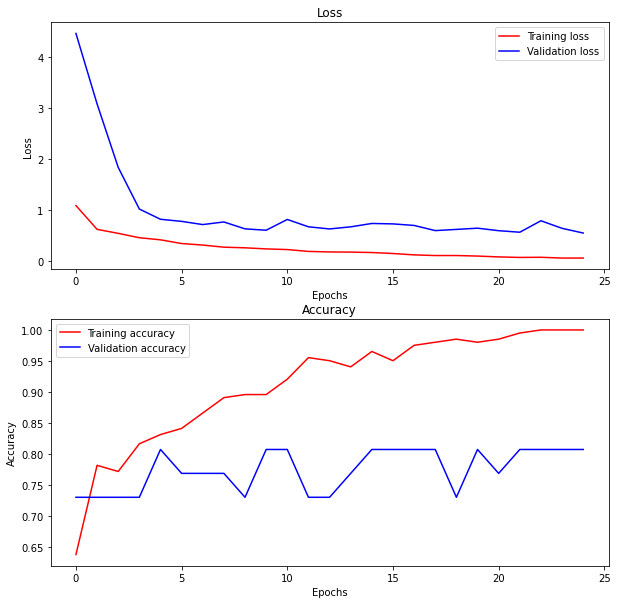

In [16]:
plot_history(history_1)

In [17]:
evalute_model(model_1, X_light_test, Y_light_test, batch_size=32)

Actuals: [1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
Predictions: [1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
[[15  0]
 [ 2  8]]
              precision    recall  f1-score   support

          no       0.88      1.00      0.94        15
         yes       1.00      0.80      0.89        10

    accuracy                           0.92        25
   macro avg       0.94      0.90      0.91        25
weighted avg       0.93      0.92      0.92        25

Accuracy: 0.920000


(0.92,
 array([[15,  0],
        [ 2,  8]]))

In [18]:
model_1.save('./Save_model/model_1.h5')

VGG 16

In [19]:
model_2 = build_vgg16()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


/Users/arshlalani/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [20]:
history_2 = train_vgg16(model_2, train_light_generator,validation_light_generator, epochs=25)

Epoch 1/25
4/4 [==============================] - 7s 2s/step - loss: 0.6927 - accuracy: 0.5312 - val_loss: 3.2813 - val_accuracy: 0.3750
Epoch 2/25
4/4 [==============================] - 5s 1s/step - loss: 0.7604 - accuracy: 0.6562 - val_loss: 5.8482 - val_accuracy: 0.5000
Epoch 3/25
4/4 [==============================] - 7s 2s/step - loss: 0.6414 - accuracy: 0.5938 - val_loss: 3.9874 - val_accuracy: 0.6250
Epoch 4/25
4/4 [==============================] - 5s 1s/step - loss: 0.6571 - accuracy: 0.6250 - val_loss: 2.9960 - val_accuracy: 0.7500
Epoch 5/25
4/4 [==============================] - 5s 1s/step - loss: 0.6055 - accuracy: 0.8077 - val_loss: 1.5573 - val_accuracy: 0.5000
Epoch 6/25
4/4 [==============================] - 6s 1s/step - loss: 0.7220 - accuracy: 0.6923 - val_loss: 6.6171 - val_accuracy: 0.5000
Epoch 7/25
4/4 [==============================] - 7s 2s/step - loss: 0.6042 - accuracy: 0.6562 - val_loss: 1.8421 - val_accuracy: 0.8750
Epoch 8/25
4/4 [=========================

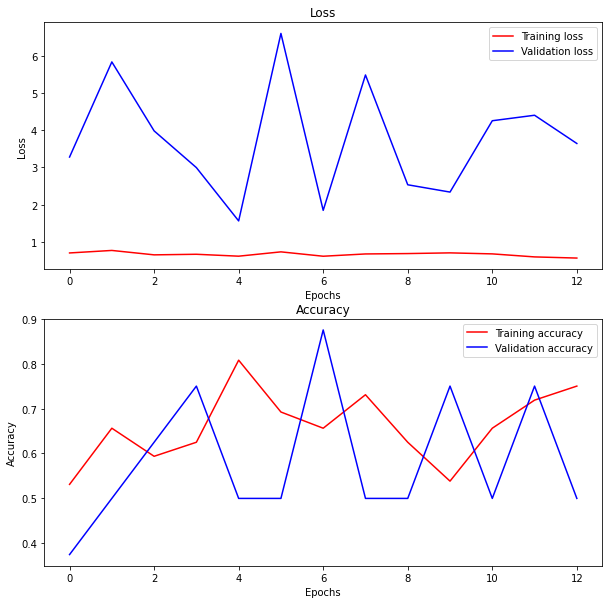

In [21]:
plot_history(history_2)

In [22]:
# Evaluate the model
evalute_model(model_2, X_light_test, Y_light_test, batch_size=5)


Actuals: [1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
Predictions: [1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1]
[[ 2 13]
 [ 1  9]]
              precision    recall  f1-score   support

          no       0.67      0.13      0.22        15
         yes       0.41      0.90      0.56        10

    accuracy                           0.44        25
   macro avg       0.54      0.52      0.39        25
weighted avg       0.56      0.44      0.36        25

Accuracy: 0.440000


(0.44,
 array([[ 2, 13],
        [ 1,  9]]))

RESNET

In [23]:
model_3 = build_resnet()

/Users/arshlalani/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [24]:
history_3 = train_resnet(model_3, X_light_train, Y_light_train, X_light_val, Y_light_val, epochs=25)

Epoch 1/25
26/26 [==============================] - 17s 567ms/step - loss: 0.6669 - accuracy: 0.6287 - val_loss: 0.6852 - val_accuracy: 0.6538
Epoch 2/25
26/26 [==============================] - 13s 514ms/step - loss: 0.5931 - accuracy: 0.6832 - val_loss: 0.6355 - val_accuracy: 0.6923
Epoch 3/25
26/26 [==============================] - 15s 575ms/step - loss: 0.5381 - accuracy: 0.7525 - val_loss: 0.6091 - val_accuracy: 0.6923
Epoch 4/25
26/26 [==============================] - 14s 551ms/step - loss: 0.4973 - accuracy: 0.8020 - val_loss: 0.5844 - val_accuracy: 0.7692
Epoch 5/25
26/26 [==============================] - 15s 568ms/step - loss: 0.4606 - accuracy: 0.8069 - val_loss: 0.5760 - val_accuracy: 0.7692
Epoch 6/25
26/26 [==============================] - 14s 542ms/step - loss: 0.4362 - accuracy: 0.8465 - val_loss: 0.5528 - val_accuracy: 0.7692
Epoch 7/25
26/26 [==============================] - 14s 545ms/step - loss: 0.4140 - accuracy: 0.8762 - val_loss: 0.5468 - val_accuracy: 0.7692

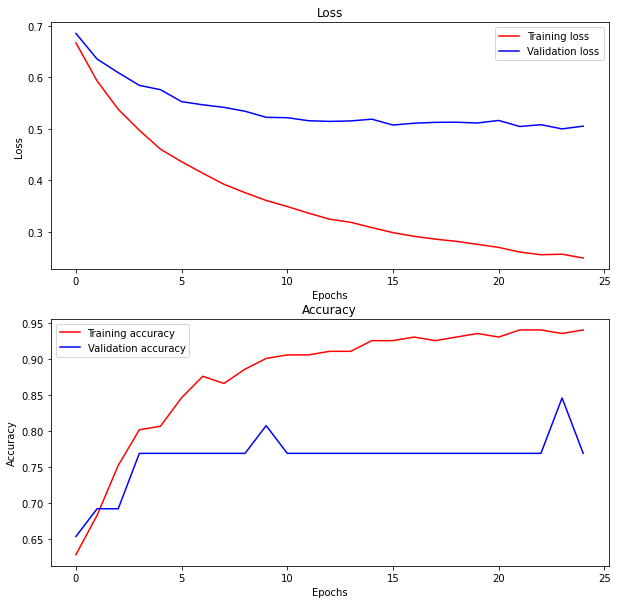

In [25]:
plot_history(history_3)

In [26]:
# Evaluate the model
evalute_model(model_3, X_light_test, Y_light_test, batch_size=32)

Actuals: [1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
Predictions: [1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1]
[[14  1]
 [ 2  8]]
              precision    recall  f1-score   support

          no       0.88      0.93      0.90        15
         yes       0.89      0.80      0.84        10

    accuracy                           0.88        25
   macro avg       0.88      0.87      0.87        25
weighted avg       0.88      0.88      0.88        25

Accuracy: 0.880000


(0.88,
 array([[14,  1],
        [ 2,  8]]))

In [27]:
model_3.save('./Save_model/model_3.h5')

/Users/arshlalani/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
